<a href="https://colab.research.google.com/github/tagakj/CL_2025_PROJECT_1/blob/main/project_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from bs4 import BeautifulSoup
import re
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk.collocations import *
nltk.download("stopwords")
nltk.download("punkt_tab")
from nltk.probability import FreqDist

import string
from string import punctuation

from collections import Counter, defaultdict

import spacy
nlp = spacy.load("en_core_web_sm")

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import numpy as np
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# считываем данные парсинга из файла
mix2800_df = pd.read_excel("mix2800_df.xlsx")

In [4]:
mix2800_df

,link,description,text
0,https://www.prnewswire.com/news-releases/auror...,"[<ul type=""disc"">\n<li><b><i>Achieves Record A...","[<p><span class=""legendSpanClass""><span class=..."
1,https://www.prnewswire.com/news-releases/li-ba...,"[<ul type=""disc"">\n<li>Revenue - for the six m...","[<p><span class=""legendSpanClass"">JIANGYIN, <s..."
2,https://www.prnewswire.com/news-releases/kirkl...,"[<ul type=""disc"">\n<li><i>Net sales of <span c...","[<p><span class=""legendSpanClass""><span class=..."
3,https://www.prnewswire.com/news-releases/lenna...,"[<ul type=""disc"">\n<li>Net earnings per dilute...",[<p><b>Second Quarter 2025 Highlights - compar...
4,https://www.prnewswire.com/news-releases/tal-e...,[],"[<p><span class=""legendSpanClass""><span class=..."
...,...,...,...
2795,https://www.prnewswire.com/news-releases/phoen...,"[<ul type=""disc"">\n<li>Total assets under mana...","[<p><span class=""legendSpanClass""><span class=..."
2796,https://www.prnewswire.com/news-releases/green...,"[<ul type=""disc"">\n<li>Greenway produced a net...","[<p><span class=""legendSpanClass""><span class=..."
2797,https://www.prnewswire.com/news-releases/luca-...,"[<ul type=""disc"">\n<li>Despite several planned...","[<p><span class=""legendSpanClass""><span class=..."
2798,https://www.prnewswire.com/news-releases/arbe-...,"[<ul type=""disc"">\n<li>Our goal of achieving 4...","[<p><span class=""legendSpanClass""><span class=..."


In [7]:
# переносим данные из таблицы в два список
des = mix2800_df["description"].tolist()
text = mix2800_df["text"].tolist()

In [8]:
# достаем текст из тэгов <ul type="disc">
bulletpoints = []
for element in des:
  bps = str('')
  soup = BeautifulSoup(element)
  for i in soup.find_all('ul', {'type': 'disc'}):
    bp = i.text
    bps = bps + bp
  bulletpoints.append(bps)
print(len(bulletpoints))

2800


In [9]:
# достаем текст из тэгов <p>
paragraphs = []
for element in text:
  prg = str('')
  soup = BeautifulSoup(element)
  for i in soup.find_all('p', {'class': None}):
    p = i.text
    prg = prg + p
  paragraphs.append(prg)
print(len(paragraphs))

2800


In [10]:
# для каждого пресс-релиза соединяем тексты из разных тэгов
press_releases = []
for i in range(len(text)):
  pr_text = bulletpoints[i] + ' ' + paragraphs[i]
  press_releases.append(pr_text)
print(len(press_releases))

2800


In [11]:
# сохраняем полные тексты пресс-релизов в файл
press_releases_df = pd.DataFrame(press_releases)
press_releases_df.to_excel("press_releases.xlsx")

In [12]:
press_releases_df

,0
0,\nAchieves Record Annual Global Medical Cannab...
1,\nRevenue - for the six months ended December ...
2,\nNet sales of $81.5 million; consolidated com...
3,\nNet earnings per diluted share of $1.81 ($1....
4,"[BEIJING, June 16, 2025 /PRNewswire/ -- TAL E..."
...,...
2795,\nTotal assets under management increased to N...
2796,"\nGreenway produced a net revenue of $1,806,95..."
2797,\nDespite several planned and unplanned mill s...
2798,\nOur goal of achieving 4 design-ins with auto...


In [13]:
# проверка что лежит в списке
print("Количество пресс-релизов", len(press_releases))
print("Тип данных в произвольном релизе", type(press_releases[2]))
print("Часть его текста", press_releases[2][:100])

Количество пресс-релизов 2800
Тип данных в произвольном релизе <class 'str'>
Часть его текста 
Net sales of $81.5 million; consolidated comparable sales decreased 8.9%, inclusive of comparable s


In [14]:
# чтобы смотреть тексты глазами для разных целей
with open("press_releases.txt", 'w', encoding = 'utf-8') as file:
  for pr in press_releases:
    file.write(pr)

In [15]:
# предобработка - очистка от переносов, лишних пробелов и замена денежных сумм
pr_clean = [] # оставляем пунктуацию!
for pr in press_releases:
  clean_text = re.sub(r'\n', ' ', pr)
  clean_text = re.sub(r'\xa0', ' ', clean_text)
  clean_text = re.sub(r'\d+\.?', 'X', clean_text) # замена денежных сумм
  clean_text = re.sub(r'X+', 'X', clean_text) # замена задвоенных ХХ
  clean_text = re.sub(r'\/', '', clean_text)
  clean_text = re.sub(r'\.', '\. ', clean_text)
  clean_text = re.sub(r'\\', '', clean_text)
  clean_text = re.sub(r'[\[\]]', '', clean_text)
  clean_text = re.sub(r'\s+', ' ', clean_text.lower())
  pr_clean.append(clean_text)
print(len(pr_clean))
print(type(pr_clean))
print(pr_clean[-1][:100])

2800
<class 'list'>
 in august, collplant announced the launch of a pre-clinical study with xcc commercial-sized breast 


In [18]:
# достаем только цитаты менеджмента, прямая речь в кавычках
only_quotes = []
for pr in pr_clean:
  q = str('')
  quotes = re.findall(r'\"(.*?)\"', pr)
  for i in quotes:
    if len(i) > 30: # проверка на кол-во символов внутри кавычек, чтобы исключить отдельные "закавыченные" слова
      q = q + ' ' + i
  only_quotes.append(q)

print(len(only_quotes))
print(len(only_quotes[-1]))
only_quotes[-1][:100]

2800
1577


' we are now one step closer to advancing our breast implant program into human studies, after develo'

In [20]:
# запишем цитаты в файл
only_quotes_df = pd.DataFrame(only_quotes)
only_quotes_df.to_excel("only_quotes.xlsx")

In [21]:
# чтобы смотреть тексты глазами для разных целей
with open("only_quotes.txt", 'w', encoding = 'utf-8') as file:
  for pr in only_quotes:
    file.write(pr)

In [22]:
# очистка цитат от знаков препинания
clean_quotes = []
for pr in only_quotes:
  clean_q = re.sub(r'[\.\?\!\,\;\:\"\~\•\*]', '', pr)
  clean_quotes.append(clean_q)
print(len(clean_quotes))
print(len(clean_quotes[-1]))
print(clean_quotes[-1][:100])

2800
1562
 we are now one step closer to advancing our breast implant program into human studies after develop


In [27]:
# словарь стоп-слов скорректирован
stop_words = stopwords.words("english")

stop_words.remove('up')
stop_words.remove('down')
stop_words.remove('i')
stop_words.remove('we')
stop_words.extend(['first', 'second', 'third', 'fourth', 'quarter'])

In [28]:
# лемматизация ЧИСТЫХ ЦИТАТ (без знаков препинания), минус стоп-слова, частеречная разметка
quotes_tokens = []
quotes_tags = []

total_tokens = [] # один общий список токенов
total_tags = [] # один общий список pos тэгов

for pr in clean_quotes:
  pr_quotes_tokens = []
  pr_quotes_tags = []
  doc = nlp(pr)
  for word in doc:
    lem = word.lemma_
    tag = word.pos_
    if lem not in stop_words:
      pr_quotes_tokens.append(lem)
      pr_quotes_tags.append(tag)
      total_tokens.append(lem)
      total_tags.append(tag)

  quotes_tokens.append(pr_quotes_tokens)
  quotes_tags.append(pr_quotes_tags)

In [32]:
# проверка
print(len(quotes_tokens))
print(len(quotes_tags))
print(len(total_tokens), "Кол-во токенов всего")
print(len(set(total_tokens)), "Кол-во уникальных токенов")
print(len(total_tags), "Кол-во тэгов")

2800
2800
467273 Кол-во токенов всего
13894 Кол-во уникальных токенов
467273 Кол-во тэгов


In [45]:
# создаем отдельно списки сущ, глаг, прилаг
nouns = []
verbs = []
adjs = []
adv = []
other_pos = []
for i in range(0, len(total_tags)):
  if total_tags[i] == 'NOUN':
    nouns.append(total_tokens[i])
  elif total_tags[i] == 'VERB':
    verbs.append(total_tokens[i])
  elif total_tags[i] == 'ADJ':
    adjs.append(total_tokens[i])
  elif total_tags[i] == 'ADV':
    adv.append(total_tokens[i])
  else:
    other_pos.append(total_tokens[i])

print(len(nouns), 'существительных')
print(nouns[:5])
print(len(verbs), 'глаголов')
print(verbs[:5])
print(len(adjs), 'прилагательных')
print(adjs[:5])
print(len(adv), 'наречий')
print(adv[:5])
print(len(other_pos))
print(other_pos[:5])

201375 существительных
['year', 'shareholder', 'record', 'ebitdax', 'cash']
77551 глаголов
['report', 'highlight', 'adjust', 'underscore', 'set']
73506 прилагательных
['pleased', 'exceptional', 'annual', 'global', 'medical']
15446 наречий
['far', 'apart', 'far', 'also', 'significantly']
99395
[' ', 'we', 'revenuex', 'we', 'qx']


In [46]:
stat_df = pd.DataFrame([len(total_tokens), len(set(total_tokens)), len(set(total_tokens))/len(total_tokens)], index = ['total tokens', 'unique tokens', 'ttr']).rename(columns={0: "##"})
pd.options.display.float_format = '{:.2f}'.format
stat_df

,##
total tokens,467273.00
unique tokens,13894.00
ttr,0.03


In [47]:
tags_freqs.most_common(20)

[('NOUN', 201375),
 ('VERB', 77551),
 ('ADJ', 73506),
 ('PUNCT', 29176),
 ('PROPN', 20856),
 ('ADV', 15446),
 ('PRON', 12554),
 ('SYM', 7935),
 ('NUM', 7660),
 ('SPACE', 5436),
 ('ADP', 5415),
 ('PART', 4230),
 ('X', 2145),
 ('AUX', 1592),
 ('SCONJ', 1099),
 ('DET', 588),
 ('CCONJ', 452),
 ('INTJ', 257)]

In [49]:
nouns_freqs = Counter(nouns)
verbs_freqs = Counter(verbs)
adjs_freqs = Counter(adjs)
adv_freqs = Counter(adv)
other_pos_freqs = Counter(other_pos)

In [50]:
frequencies_df = pd.DataFrame([nouns_freqs.most_common(5), verbs_freqs.most_common(5), adjs_freqs.most_common(5), adv_freqs.most_common(5),other_pos_freqs.most_common(5)]).T.rename(columns={0: "nouns", 1: "verbs", 2: "adjs", 3: "adv", 4: "other"})
frequencies_df

,nouns,verbs,adjs,adv,other
0,"(year, 5611)","(continue, 3054)","(financial, 2904)","(forward, 1602)","(x, 15821)"
1,"(company, 3874)","(include, 2070)","(-, 2729)","(well, 1295)","(we, 11577)"
2,"(growth, 3700)","(look, 1797)","(net, 2272)","(also, 1015)","(-, 10462)"
3,"(business, 2756)","(deliver, 1659)","(strong, 2167)","(approximately, 581)","($, 4879)"
4,"(result, 2738)","(drive, 1589)","(non, 1988)","(primarily, 507)","( , 4741)"


In [52]:
combined = nouns + verbs + adjs
combined_freqs = Counter(combined)
combined_freqs.most_common(10)

[('year', 5613),
 ('company', 3876),
 ('growth', 3705),
 ('-', 3575),
 ('result', 3147),
 ('continue', 3054),
 ('financial', 2919),
 ('business', 2763),
 ('increase', 2459),
 ('net', 2388)]

<function matplotlib.pyplot.show(close=None, block=None)>

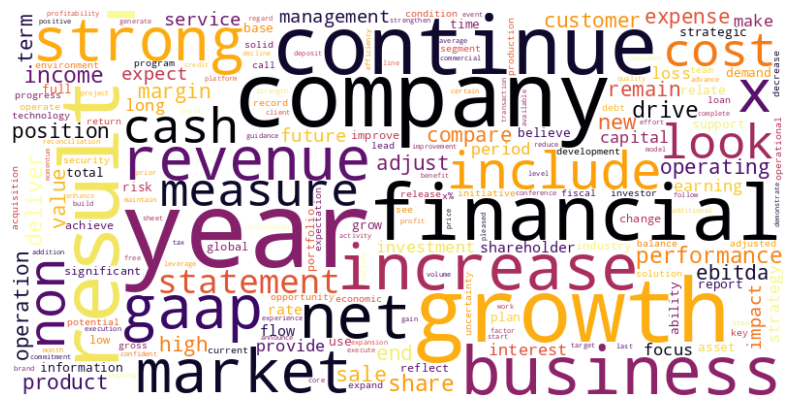

In [ ]:
# облако для общего списка сущ, глаголов, прил
wc_combined = WordCloud(background_color='white', colormap = 'inferno_r', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(combined_freqs)
plt.figure(figsize=(10, 8))
plt.imshow(wc_combined, interpolation="bilinear")
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

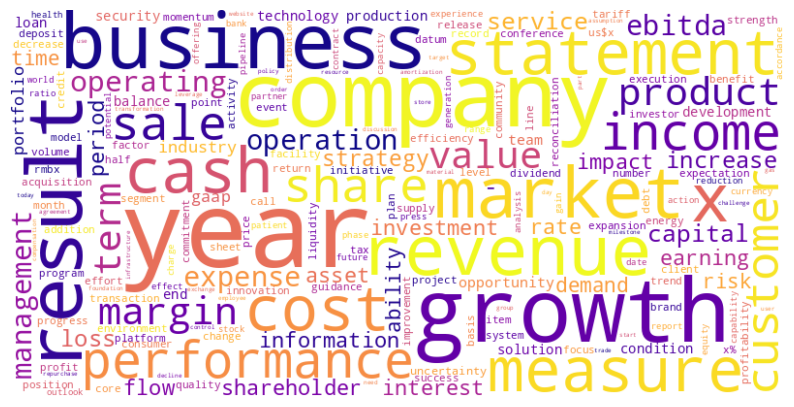

In [ ]:
# облако для существительных
wc_nouns = WordCloud(background_color='white', colormap = 'plasma', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(nouns_freqs)
plt.figure(figsize=(10, 8))
plt.imshow(wc_nouns, interpolation="bilinear")
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

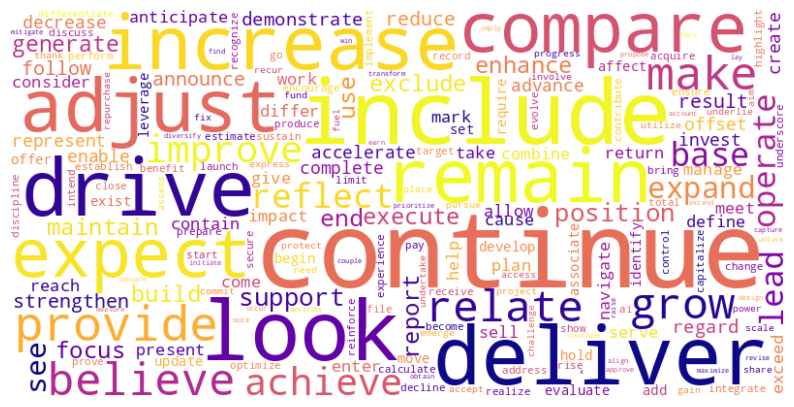

In [ ]:
# облако для глаголов
wc_verbs = WordCloud(background_color='white', colormap = 'plasma', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(verbs_freqs)
plt.figure(figsize=(10, 8))
plt.imshow(wc_verbs, interpolation="bilinear")
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

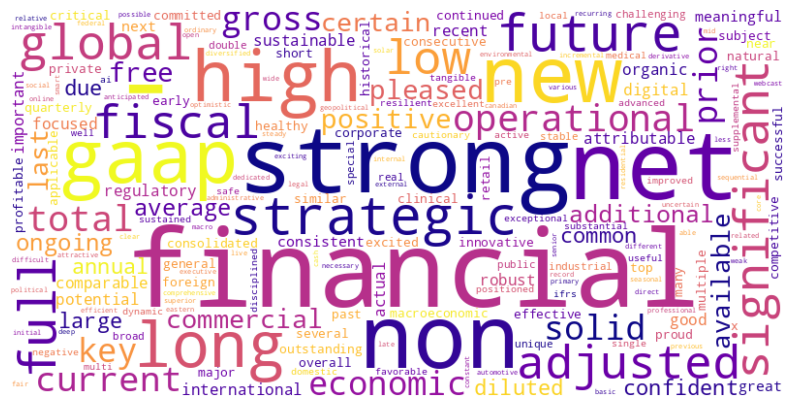

In [ ]:
# облако для прилагательных
wc_adjs = WordCloud(background_color='white', colormap = 'plasma', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(adjs_freqs)
plt.figure(figsize=(10, 8))
plt.imshow(wc_adjs, interpolation="bilinear")
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

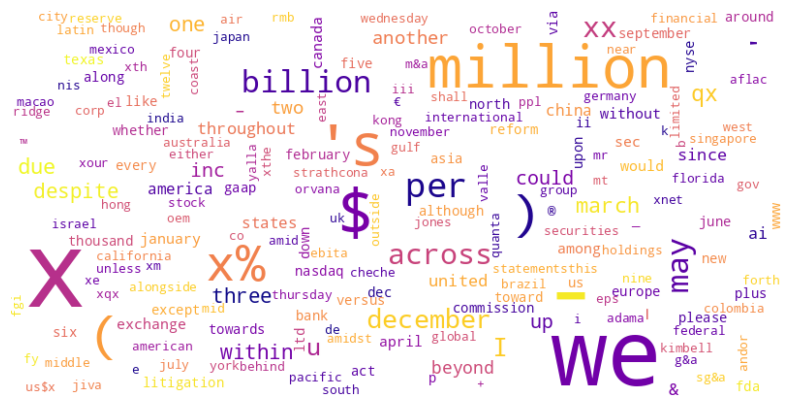

In [53]:
# облако для всего остального, видно много мусора
wc_other = WordCloud(background_color='white', colormap = 'plasma', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(other_pos_freqs)
plt.figure(figsize=(10, 8))
plt.imshow(wc_other, interpolation="bilinear")
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

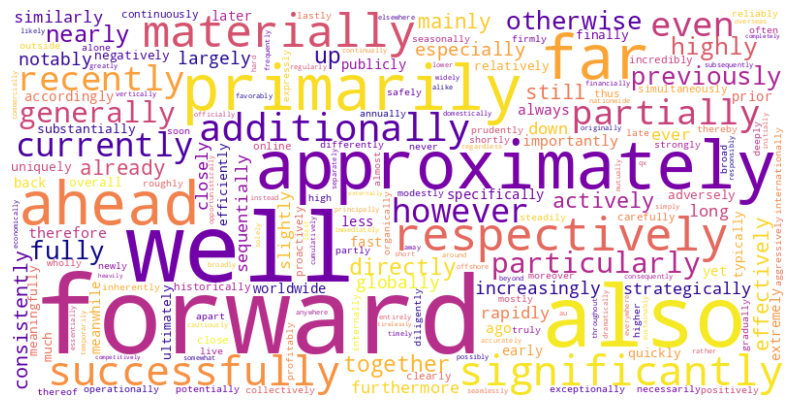

In [51]:
# облако для наречий
wc_adv = WordCloud(background_color='white', colormap = 'plasma', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(adv_freqs)
plt.figure(figsize=(10, 8))
plt.imshow(wc_adv, interpolation="bilinear")
plt.axis("off")
plt.show

In [54]:
# negative_words from Loughran-McDonald Sentiment Word Lists
negative = pd.read_excel("NEGATIVE_WORDS.xlsx")
negative_words = negative[0].tolist()
print(len(negative_words))

2355


In [55]:
# positive_words Loughran-McDonald Sentiment Word Lists
positive = pd.read_excel("POSITIVE_WORDS.xlsx")
positive_words = positive[0].tolist()
print(len(positive_words))

354


In [56]:
# счетчик позитивных и негативных слов по цитатам менеджмента
ratio = []
positive_tokens = []
negative_tokens = []
unknown = []
index = 0
#for i in range(len(quotes_tokens)):
for pr in quotes_tokens:
  pr_positive = 0
  pr_negative = 0
  pr_unknown = 0
  for token in pr:
    if token in positive_words:
      positive_tokens.append(token)
      pr_positive = pr_positive + 1
    elif token in negative_words:
      negative_tokens.append(token)
      pr_negative = pr_negative + 1
    else:
      unknown.append(token)
      pr_unknown = pr_unknown + 1
  ratio.append([pr_positive, pr_negative, pr_unknown])
  index = index + 1

In [58]:
# проверка
print(len(positive_tokens), "positive")
print(len(set(positive_tokens)), "unique positive")
print(len(negative_tokens), "negative")
print(len(set(negative_tokens)), "unique negative")
print(len(unknown), "unknown")
print(len(set(unknown)), "unique unknown")
print(positive_tokens[:5])
print(negative_tokens[:5])
print(unknown[:5])
print(len(ratio))

17257 positive
181 unique positive
6479 negative
414 unique negative
443537 unknown
13299 unique unknown
['pleased', 'exceptional', 'positive', 'achievement', 'strengthen']
['cautionary', 'challenge', 'exacerbate', 'late', 'disruption']
[' ', 'we', 'report', 'year', 'shareholder']
2800


In [60]:
# попытка убрать оставшийся мусор для презентации no-mood токенов
bin = ['-', ' ', '\'s', '(', ')']
for i in bin:
  for token in unknown:
    if i == token:
      unknown.remove(token)
print(len(unknown))
print(len(set(unknown)))

415765
13298


In [63]:
# частотники по поз/нег/no-mood токенам
pos_freq = Counter(positive_tokens)
neg_freq = Counter(negative_tokens)
unkn_freq = Counter(unknown)
mood_df = pd.DataFrame([pos_freq.most_common(15), neg_freq.most_common(15), unkn_freq.most_common(15)]).T.rename(columns={0: "positive", 1: "negative", 2: "no_mood"})
mood_df

,positive,negative,no_mood
0,"(strong, 2169)","(loss, 1022)","(x, 18096)"
1,"(improve, 766)","(decline, 389)","(we, 11578)"
2,"(achieve, 760)","(challenge, 338)","(year, 5613)"
3,"(opportunity, 721)","(litigation, 168)","($, 4879)"
4,"(progress, 567)","(volatility, 151)","(million, 4107)"
5,"(profitability, 521)","(critical, 146)","(company, 3885)"
6,"(improvement, 517)","(challenging, 145)","(growth, 3705)"
7,"(positive, 514)","(limitation, 139)","(x%, 3607)"
8,"(enhance, 514)","(impairment, 138)","(result, 3147)"
9,"(pleased, 498)","(negative, 131)","(continue, 3057)"


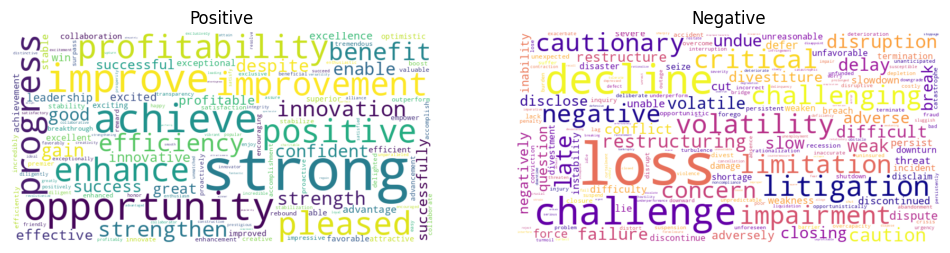

In [ ]:
# облака слов позитивных и негативных
pos_wc = WordCloud(background_color='white', colormap = 'viridis', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(pos_freq)
neg_wc = WordCloud(background_color='white', colormap = 'plasma', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(neg_freq)

#plt.figure(figsize=(10, 8))
#plt.imshow(tol_wc, interpolation="bilinear")
#plt.axis("off")
#plt.show

# Визуализируйте
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(pos_wc, interpolation='bilinear')
ax1.set_title('Positive')
ax1.axis('off')

ax2.imshow(neg_wc, interpolation='bilinear')
ax2.set_title('Negative')
ax2.axis('off')

plt.show()

In [65]:
# таблица с кол-вом поз, нег и др токенов для каждого релиза
ratio_df = pd.DataFrame(ratio)
ratio_df.to_excel("ratio_count.xlsx")
ratio_df

,0,1,2
0,11,1,85
1,0,0,0
2,6,8,152
3,10,6,270
4,0,0,0
...,...,...,...
2795,8,1,168
2796,2,0,86
2797,6,0,121
2798,6,1,92


In [66]:
# подсчёт процентов поз/нег токенов для каждого релиза
df_pos = ratio_df[0] / (ratio_df[0] + ratio_df[1] +ratio_df[2])
df_neg = ratio_df[1] / (ratio_df[0] + ratio_df[1] +ratio_df[2])

In [67]:
# сохранение процентов в таблицу
df = pd.concat([df_pos, df_neg], axis = 1)
df_cleaned = df.dropna() # удаляем строки с NA
df_cleaned


,0,1
0,0.11,0.01
2,0.04,0.05
3,0.03,0.02
5,0.09,0.00
6,0.06,0.02
...,...,...
2795,0.05,0.01
2796,0.02,0.00
2797,0.05,0.00
2798,0.06,0.01


In [68]:
# считаем средние
pos_mean = df_cleaned[0].mean()
neg_mean = df_cleaned[1].mean()
print(pos_mean)
print(neg_mean)

0.05561872237189575
0.011104122317311027


In [69]:
# считаем разницу (% поз - % нег) для построения зеленого графика
diff_df = df_cleaned[0] - df_cleaned[1]
diff_df

,0
0,0.10
2,-0.01
3,0.01
5,0.09
6,0.04
...,...
2795,0.04
2796,0.02
2797,0.05
2798,0.05


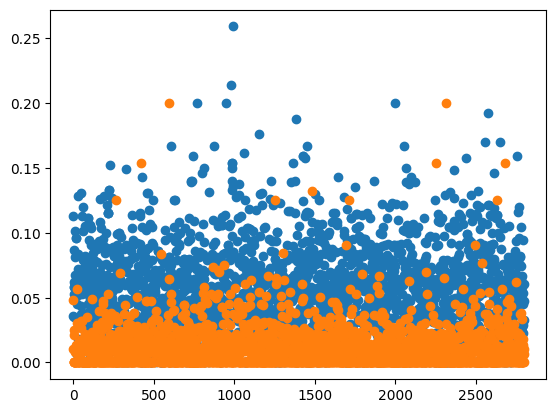

In [ ]:
plt.plot(df_cleaned[0], 'o', df_cleaned[1], 'o')
plt.show()

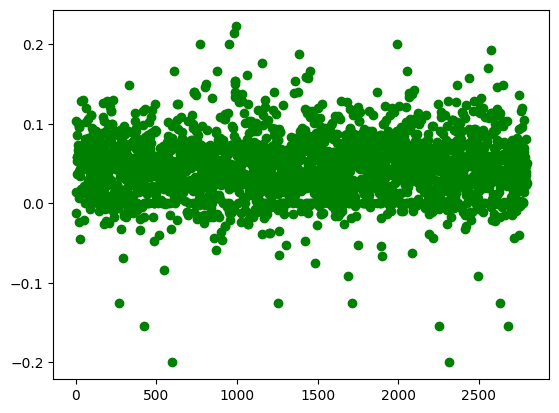

In [ ]:
plt.plot(diff_df, 'o', color = 'green')
plt.show()

In [76]:
# функция для подсчёта кол-ва релизов, где токен встретился хотя бы один раз
def word_count(hippo):
  word_number = 0
  empty = 0
  total = 0
  for pr in clean_quotes:
    if hippo in pr:
      word_number = word_number + 1
  for pr in clean_quotes:
    total = total + 1
    if len(pr) == 0:
      empty = empty + 1
  return(hippo, word_number, (word_number/(total-empty)))


In [79]:
# считаем % отчетов, где токен встретился хотя бы один раз

# для топ-3 позитивных
print(word_count('strong'))
print(word_count('improve'))
print(word_count('achieve'))

# для топ-3 негативных
print(word_count('loss'))
print(word_count('decline'))
print(word_count('challenge'))


('strong', 1315, 0.5719878207916486)
('improve', 706, 0.3070900391474554)
('achieve', 533, 0.23183993040452372)
('loss', 259, 0.11265767725097868)
('decline', 168, 0.07307525010874293)
('challenge', 210, 0.09134406263592866)


КОЛЛОКАЦИИ

In [80]:
# лемматизация С СОХРАНЕНИЕМ ПРЕДЛОЖЕНИЙ, удаление стоп-слов
pr_sent_clean = []
for pr in only_quotes:
  pr_sent = sent_tokenize(pr)
  for sent in pr_sent:
    sent_clean = []
    doc = nlp(sent)
    for word in doc:
      lem = word.lemma_
      if lem not in stop_words:
        sent_clean.append(lem)
    pr_sent_clean.append(' '.join(sent_clean))

print(len(pr_sent_clean))

21471


In [83]:
# убираем пунктуацию и лишние пробелы
very_clean = []
for pr in pr_sent_clean:
  pr_clean = pr.translate({ord(char): None for char in string.punctuation})
  pr_clean = re.sub(r'\s+', ' ', pr_clean)
  very_clean.append(pr_clean)
print(len(very_clean))

21471


In [84]:
# соединяем предложения в одну строку
corpu = ' '.join(very_clean)
print(len(corpu))

3188026


In [137]:
# токенизируем для поиска н-грамм с помощью nltk
text_list_nltk = word_tokenize(corpu)

In [141]:
# поиск н-грамм
bi = nltk.bigrams(text_list_nltk)
tri = nltk.trigrams(text_list_nltk)
f4gr = nltk.ngrams(text_list_nltk, 4)
f5gr = nltk.ngrams(text_list_nltk, 5)

In [142]:
# результаты в таблицу
bi_freq = Counter(bi).most_common(30)
tri_freq = Counter(tri).most_common(30)
f4gr_freq = Counter(f4gr).most_common(30)
f5gr_freq = Counter(f5gr).most_common(30)

gramms_df = pd.DataFrame([bi_freq, tri_freq, f4gr_freq, f5gr_freq]).T
gramms_df

,0,1,2,3
0,"((x, x), 4466)","((forward, look, statement), 966)","((non, gaap, financial, measure), 547)","((management, s, discussion, analysis, financi..."
1,"((x, million), 3601)","((x, x, x), 928)","((x, x, x, x), 283)","((s, discussion, analysis, financial, conditio..."
2,"((company, s), 1585)","((x, million, x), 832)","((end, december, x, x), 234)","((discussion, analysis, financial, condition, ..."
3,"((non, gaap), 1383)","((gaap, financial, measure), 634)","((x, million, x, million), 202)","((analysis, financial, condition, result, oper..."
4,"((forward, look), 1205)","((non, gaap, financial), 622)","((management, s, discussion, analysis), 158)","((year, end, december, x, x), 114)"
5,"((we, continue), 970)","((december, x, x), 511)","((financial, condition, result, operation), 145)","((private, security, litigation, reform, act),..."
6,"((look, statement), 968)","((x, x, million), 469)","((s, discussion, analysis, financial), 129)","((security, litigation, reform, act, x), 91)"
7,"((x, we), 926)","((free, cash, flow), 385)","((discussion, analysis, financial, condition),...","((x, million, compare, x, million), 91)"
8,"((long, term), 917)","((march, x, x), 342)","((analysis, financial, condition, result), 129)","((month, end, december, x, x), 91)"
9,"((million, x), 911)","((x, year, year), 323)","((year, end, december, x), 125)","((use, non, gaap, financial, measure), 85)"


In [143]:
# сохраним в файл
gramms_df.to_excel("gramms.xlsx")

In [162]:
# ищем коллокации с помощью t-student
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_big = BigramCollocationFinder.from_words(word_tokenize(corpu))
scores_raw_bi = finder_big.score_ngrams(bigram_measures.student_t)

In [300]:
scores_raw_bi[:10]

[(('x', 'million'), 56.349013364535324),
 (('x', 'x'), 48.12736794012535),
 (('company', 's'), 38.77689696949056),
 (('non', 'gaap'), 36.91591485825441),
 (('forward', 'look'), 34.518501901754405),
 (('look', 'statement'), 30.8811740254161),
 (('long', 'term'), 30.17364850355293),
 (('cash', 'flow'), 29.24091870041149),
 (('we', 'continue'), 28.586102784894113),
 (('financial', 'measure'), 27.443274623028287)]

In [164]:
# 3-граммы t-student
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder_trig = TrigramCollocationFinder.from_words(word_tokenize(corpu))
scores_raw_tri = finder_trig.score_ngrams(trigram_measures.student_t)

In [301]:
scores_raw_tri[:10]

[(('forward', 'look', 'statement'), 31.079670236081554),
 (('x', 'million', 'x'), 28.43766703260671),
 (('x', 'x', 'x'), 28.271221818939146),
 (('gaap', 'financial', 'measure'), 25.176954308716297),
 (('non', 'gaap', 'financial'), 24.937184143245794),
 (('december', 'x', 'x'), 22.52297548210129),
 (('x', 'x', 'million'), 21.11466207890876),
 (('free', 'cash', 'flow'), 19.621177450475802),
 (('march', 'x', 'x'), 18.423781242281585),
 (('x', 'year', 'year'), 17.758114107516946)]

In [166]:
# 4-граммы t-student
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()
finder_4grams = QuadgramCollocationFinder.from_words(word_tokenize(corpu))
scores_raw_four = finder_4grams.score_ngrams(fourgram_measures.student_t)

In [302]:
scores_raw_four[:10]

[(('non', 'gaap', 'financial', 'measure'), 23.388019211666332),
 (('x', 'x', 'x', 'x'), 16.61054043234776),
 (('end', 'december', 'x', 'x'), 15.296722272101041),
 (('x', 'million', 'x', 'million'), 14.204920981088446),
 (('management', 's', 'discussion', 'analysis'), 12.569804796796452),
 (('financial', 'condition', 'result', 'operation'), 12.041587451667915),
 (('discussion', 'analysis', 'financial', 'condition'), 11.357816579212338),
 (('s', 'discussion', 'analysis', 'financial'), 11.35781588508052),
 (('analysis', 'financial', 'condition', 'result'), 11.357815075570993),
 (('year', 'end', 'december', 'x'), 11.180229443961228)]

In [168]:
# коллокации с окном, не дало отличных от предыдущих результатов
finder_big_win = BigramCollocationFinder.from_words(word_tokenize(corpu), window_size=5)
scores_tscore_win = finder_big_win.score_ngrams(bigram_measures.student_t)

In [303]:
scores_tscore_win[:10]

[(('x', 'x'), 38.26811936153595),
 (('x', 'million'), 30.95912996368404),
 (('non', 'gaap'), 18.607561822620134),
 (('company', 's'), 18.48296621462028),
 (('million', 'x'), 18.367891227481238),
 (('forward', 'look'), 17.475190222966635),
 (('gaap', 'measure'), 16.6834029332051),
 (('look', 'statement'), 16.462843314442132),
 (('december', 'x'), 16.40729578116544),
 (('x', 'compare'), 15.826755917540332)]

In [175]:
# POS-tagging склейка
tagged = []
for i in range(len(total_tokens)):
  tagged_token = total_tokens[i] + '_' + total_tags[i]
  tagged.append(tagged_token)

In [176]:
# проверка
print(tagged[:5])

[' _SPACE', 'we_PRON', 'pleased_ADJ', 'report_VERB', 'exceptional_ADJ']


In [177]:
# склейка всех токенов с pos-тэгами в один текст
tagged_text = ' '.join(tagged)
print(tagged_text[:100])

 _SPACE we_PRON pleased_ADJ report_VERB exceptional_ADJ year_NOUN shareholder_NOUN highlight_VERB re


In [178]:
finder_big = BigramCollocationFinder.from_words(word_tokenize(tagged_text))
scores_student_t = finder_big.score_ngrams(bigram_measures.student_t)

In [184]:
bigrams_with_nouns = []
for bigram_measured in scores_student_t:
  if re.match(r'\w+_NOUN', bigram_measured[0][0]):
    bigrams_with_nouns.append(bigram_measured)
bigrams_with_nouns[:10]

[(('company_NOUN', "'s_PART"), 39.03659903936676),
 (('cash_NOUN', 'flow_NOUN'), 28.45299651746216),
 (('x_NOUN', '-_NOUN'), 22.655321354126507),
 (('year_NOUN', '-_PUNCT'), 22.471306893017086),
 (('balance_NOUN', 'sheet_NOUN'), 21.01955880875939),
 (('x_NOUN', 'per_ADP'), 19.72588606959228),
 (('revenue_NOUN', 'growth_NOUN'), 19.661114351713188),
 (('conference_NOUN', 'call_NOUN'), 17.44201002766083),
 (('press_NOUN', 'release_NOUN'), 16.653824713694128),
 (('earning_NOUN', 'per_ADP'), 15.844905045786984)]

In [185]:
bigrams_with_verbs = []
for bigram_measured in scores_student_t:
  if re.match(r'\w+_VERB', bigram_measured[0][0]):
    bigrams_with_verbs.append(bigram_measured)
bigrams_with_verbs[:10]

[(('look_VERB', 'statement_NOUN'), 30.71267212323927),
 (('adjust_VERB', 'ebitda_NOUN'), 19.05905313118523),
 (('look_VERB', 'ahead_ADV'), 16.479229565140436),
 (('increase_VERB', 'x'), 16.23203255457049),
 (('compare_VERB', '$'), 16.071543057048093),
 (('end_VERB', 'december_PROPN'), 15.76229768627447),
 (('remain_VERB', 'focused_ADJ'), 14.366243882840203),
 (('increase_VERB', '$'), 13.763407119374817),
 (('look_VERB', 'forward_ADV'), 13.72511254401056),
 (('differ_VERB', 'materially_ADV'), 13.519176575432157)]

In [186]:
bigrams_with_adj = []
for bigram_measured in scores_student_t:
  if re.match(r'\w+_ADJ', bigram_measured[0][0]) and re.match(r'\w+_NOUN', bigram_measured[0][1]):
    bigrams_with_adj.append(bigram_measured)
bigrams_with_adj[:10]

[(('financial_ADJ', 'measure_NOUN'), 27.385902199283414),
 (('net_ADJ', 'income_NOUN'), 24.689501485260074),
 (('full_ADJ', 'year_NOUN'), 21.5188816445682),
 (('adjusted_ADJ', 'ebitda_NOUN'), 21.13302671365268),
 (('free_ADJ', 'cash_NOUN'), 20.20939820777664),
 (('fiscal_ADJ', 'year_NOUN'), 18.11278322559941),
 (('last_ADJ', 'year_NOUN'), 17.668394216491137),
 (('prior_ADJ', 'year_NOUN'), 16.46865433496778),
 (('gross_ADJ', 'margin_NOUN'), 16.14593455047377),
 (('financial_ADJ', 'performance_NOUN'), 16.038860778860546)]

In [202]:
# поиск словосочетаний со strong в коллокациях по t-student
bigrams_with_strong = []
for bigram_measured in scores_student_t:
  if re.match(r'strong_ADJ', bigram_measured[0][0]) and re.match(r'\w+_NOUN', bigram_measured[0][1]):
    bigrams_with_strong.append(bigram_measured)
bigrams_with_strong[:10]

[(('strong_ADJ', 'performance_NOUN'), 9.669942430220706),
 (('strong_ADJ', 'result_NOUN'), 9.381947182540214),
 (('strong_ADJ', 'balance_NOUN'), 9.353174064726508),
 (('strong_ADJ', 'start_NOUN'), 8.601692742828964),
 (('strong_ADJ', 'momentum_NOUN'), 7.254652550912997),
 (('strong_ADJ', 'cash_NOUN'), 7.161191257773851),
 (('strong_ADJ', 'foundation_NOUN'), 7.000316352691307),
 (('strong_ADJ', 'growth_NOUN'), 6.903076763202395),
 (('strong_ADJ', 'execution_NOUN'), 6.013600608427421),
 (('strong_ADJ', 'demand_NOUN'), 5.613488282389158)]

In [265]:
# поиск словосочетаний со strong в тэгированном тексте
res = re.findall(r'strong_ADJ\s\b\w+_NOUN', tagged_text)
res_freq = Counter(res)
res_freq.most_common(20)

[('strong_ADJ result_NOUN', 111),
 ('strong_ADJ performance_NOUN', 108),
 ('strong_ADJ balance_NOUN', 93),
 ('strong_ADJ growth_NOUN', 77),
 ('strong_ADJ start_NOUN', 76),
 ('strong_ADJ cash_NOUN', 66),
 ('strong_ADJ momentum_NOUN', 57),
 ('strong_ADJ foundation_NOUN', 51),
 ('strong_ADJ year_NOUN', 44),
 ('strong_ADJ execution_NOUN', 40),
 ('strong_ADJ demand_NOUN', 38),
 ('strong_ADJ revenue_NOUN', 33),
 ('strong_ADJ operating_NOUN', 30),
 ('strong_ADJ finish_NOUN', 28),
 ('strong_ADJ position_NOUN', 27),
 ('strong_ADJ liquidity_NOUN', 20),
 ('strong_ADJ earning_NOUN', 19),
 ('strong_ADJ capital_NOUN', 18),
 ('strong_ADJ return_NOUN', 16),
 ('strong_ADJ profitability_NOUN', 16)]

In [217]:
# для сравнения, для понимания
df = pd.DataFrame([bigrams_with_strong[:10], res_freq.most_common(10)]).T
df

,0,1
0,"((strong_ADJ, performance_NOUN), 9.66994243022...","(strong_ADJ result_NOUN, 111)"
1,"((strong_ADJ, result_NOUN), 9.381947182540214)","(strong_ADJ performance_NOUN, 108)"
2,"((strong_ADJ, balance_NOUN), 9.353174064726508)","(strong_ADJ balance_NOUN, 93)"
3,"((strong_ADJ, start_NOUN), 8.601692742828964)","(strong_ADJ growth_NOUN, 77)"
4,"((strong_ADJ, momentum_NOUN), 7.254652550912997)","(strong_ADJ start_NOUN, 76)"
5,"((strong_ADJ, cash_NOUN), 7.161191257773851)","(strong_ADJ cash_NOUN, 66)"
6,"((strong_ADJ, foundation_NOUN), 7.000316352691...","(strong_ADJ momentum_NOUN, 57)"
7,"((strong_ADJ, growth_NOUN), 6.903076763202395)","(strong_ADJ foundation_NOUN, 51)"
8,"((strong_ADJ, execution_NOUN), 6.013600608427421)","(strong_ADJ year_NOUN, 44)"
9,"((strong_ADJ, demand_NOUN), 5.613488282389158)","(strong_ADJ execution_NOUN, 40)"


In [237]:
# поиск словосочетаний в тэгированном тексте
res = re.findall(r'improve_VERB(?:\s\b\w+\b){2}', tagged_text)
res_freq = Counter(res)
res_freq.most_common(5)

[('improve_VERB operational_ADJ efficiency_NOUN', 23),
 ('improve_VERB gross_ADJ margin_NOUN', 12),
 ('improve_VERB financial_ADJ performance_NOUN', 8),
 ('improve_VERB cash_NOUN flow_NOUN', 8),
 ('improve_VERB operational_ADJ performance_NOUN', 7)]

In [239]:
# поиск словосочетаний в тэгированном тексте
res = re.findall(r'achieve_VERB(?:\s\b\w+\b){2}', tagged_text)
res_freq = Counter(res)
res_freq.most_common(10)

[('achieve_VERB significant_ADJ milestone_NOUN', 9),
 ('achieve_VERB full_ADJ year_NOUN', 8),
 ('achieve_VERB record_NOUN revenue_NOUN', 6),
 ('achieve_VERB sustainable_ADJ growth_NOUN', 5),
 ('achieve_VERB strategic_ADJ objective_NOUN', 5),
 ('achieve_VERB solid_ADJ result_NOUN', 5),
 ('achieve_VERB strong_ADJ financial_ADJ', 5),
 ('achieve_VERB remarkable_ADJ growth_NOUN', 4),
 ('achieve_VERB strong_ADJ result_NOUN', 4),
 ('achieve_VERB important_ADJ milestone_NOUN', 4)]

In [240]:
# попытки найти фразы с loss
bigrams_with_loss = []
for bigram_measured in scores_student_t:
  if re.match(r'loss_NOUN', bigram_measured[0][0]):
    bigrams_with_loss.append(bigram_measured)
bigrams_with_loss[:10]

[(('loss_NOUN', ')'), 14.786180873600943),
 (('loss_NOUN', '$'), 9.78418849772542),
 (('loss_NOUN', 'attributable_ADJ'), 7.990323040016336),
 (('loss_NOUN', 'sale_NOUN'), 5.285887631235713),
 (('loss_NOUN', 'per_ADP'), 5.201238781538795),
 (('loss_NOUN', 'rmbx_NOUN'), 3.9712740413525007),
 (('loss_NOUN', 'derivative_ADJ'), 3.560838210049296),
 (('loss_NOUN', 'disposal_NOUN'), 3.2983177958445205),
 (('loss_NOUN', 'x_PROPN'), 3.250200965578162),
 (('loss_NOUN', 'decrease_VERB'), 2.948423394032812)]

In [241]:
# попытки найти фразы с loss
bigrams_with_loss = []
for bigram_measured in scores_student_t:
  if re.match(r'loss_NOUN', bigram_measured[0][1]):
    bigrams_with_loss.append(bigram_measured)
bigrams_with_loss[:10]

[(('net_ADJ', 'loss_NOUN'), 15.41342633554303),
 (('_PUNCT', 'loss_NOUN'), 14.768118922435109),
 (('gain_NOUN', 'loss_NOUN'), 8.175119539539258),
 (('credit_NOUN', 'loss_NOUN'), 8.07613184199634),
 (('operating_NOUN', 'loss_NOUN'), 7.127990314563788),
 (('compare_VERB', 'loss_NOUN'), 3.6247900877389565),
 (('unrealized_ADJ', 'loss_NOUN'), 3.444156400565111),
 (('impairment_NOUN', 'loss_NOUN'), 3.3806943541976078),
 (('million_NUM', 'loss_NOUN'), 3.019001486545947),
 (('ebitda_NOUN', 'loss_NOUN'), 2.909885660310714)]

In [264]:
# поиск словосочетаний в тэгированном тексте
res = re.findall(r'challenging_\w+\b\s\b\w+\b', tagged_text)
res_freq = Counter(res)
res_freq.most_common(10)

[('challenging_ADJ environment_NOUN', 19),
 ('challenging_ADJ market_NOUN', 16),
 ('challenging_ADJ year_NOUN', 13),
 ('challenging_ADJ macro_ADJ', 11),
 ('challenging_ADJ economic_ADJ', 11),
 ('challenging_ADJ macroeconomic_ADJ', 9),
 ('challenging_ADJ condition_NOUN', 5),
 ('challenging_ADJ business_NOUN', 3),
 ('challenging_ADJ time_NOUN', 3),
 ('challenging_ADJ uncertain_ADJ', 3)]

In [269]:
# поиск словосочетаний в тэгированном тексте
res = re.findall(r'\b\w+_VERB\sloss_NOUN', tagged_text)
res_freq = Counter(res)
res_freq.most_common(10)

[('compare_VERB loss_NOUN', 18),
 ('operate_VERB loss_NOUN', 8),
 ('include_VERB loss_NOUN', 8),
 ('offset_VERB loss_NOUN', 4),
 ('realize_VERB loss_NOUN', 3),
 ('xoperate_VERB loss_NOUN', 3),
 ('business_VERB loss_NOUN', 3),
 ('yield_VERB loss_NOUN', 2),
 ('narrow_VERB loss_NOUN', 2),
 ('improve_VERB loss_NOUN', 2)]

In [295]:
pleased = []
for pr in pr_sent_clean:
  if "we pleased" in pr:
    pleased.append(re.findall(r'we pleased(?:\s+\b\w+\b){4}', pr))
print(len(pleased))
print(pleased[:5])

309
[['we pleased report exceptional year shareholder'], ['we pleased kick year steady growth'], ['we pleased report another solid healthy'], ['we pleased deliver earning result ahead'], ['we pleased progress we continue drive']]


In [296]:
believe = []
for pr in pr_sent_clean:
  if "we believe" in pr:
    believe.append(re.findall(r'we believe(?:\s+\b\w+\b){4}', pr))
print(len(believe))
print(believe[:5])

540
[['we believe rebuild foundation unlock significant'], ['we believe type service demand current'], ['we believe fyx even well revenue'], ['we believe market demand remain strong'], ['we believe full year pass unit']]


In [297]:
contin = []
for pr in pr_sent_clean:
  if "we continue" in pr:
    contin.append(re.findall(r'we continue(?:\s+\b\w+\b){4}', pr))
print(len(contin))
print(contin[:5])

962
[[], ['we continue see softness housing market'], ['we continue focus match production pace'], ['we continue move towards even flow'], ['we continue focus consistent volume pace']]


In [298]:
remain = []
for pr in pr_sent_clean:
  if "we remain" in pr:
    remain.append(re.findall(r'we remain(?:\s+\b\w+\b){4}', pr))
print(len(remain))
print(remain[:5])

565
[[], ['we remain committed innovation combine technology'], ['we remain focused deliver business strength'], ['we remain confident sustainable growth trajectory'], ['we remain committed disciplined balanced approach']]


In [277]:
# это была проверка с какими частями речи t-student находит remain
bigrams_with = []
for bigram_measured in scores_student_t:
    #print(bigram_measured)
    #print(bigram_measured[0][0])
    if re.match(r'remain_VERB', bigram_measured[0][0]) and re.match(r'\w+_ADJ', bigram_measured[0][1]):
        #print(bigram_measured[0][0])
       # print(bigram_measured)
        bigrams_with.append(bigram_measured)
bigrams_with[:10]

[(('remain_VERB', 'focused_ADJ'), 14.366243882840203),
 (('remain_VERB', 'committed_ADJ'), 11.954045028988178),
 (('remain_VERB', 'confident_ADJ'), 10.99497426572362),
 (('remain_VERB', 'strong_ADJ'), 8.660093382485309),
 (('remain_VERB', 'steadfast_ADJ'), 4.876114470072551),
 (('remain_VERB', 'optimistic_ADJ'), 4.744925693465791),
 (('remain_VERB', 'stable_ADJ'), 4.381580080554633),
 (('remain_VERB', 'unchanged_ADJ'), 4.219623344713505),
 (('remain_VERB', 'robust_ADJ'), 3.6475384188287308),
 (('remain_VERB', 'resilient_ADJ'), 3.5043829506952937)]

In [282]:
# поиск словосочетаний в тэгированном тексте
res = re.findall(r'we_PRON\sremain_VERB\s\w+_ADJ\b', tagged_text)
res_freq = Counter(res)
res_freq.most_common(20)

[('we_PRON remain_VERB focused_ADJ', 150),
 ('we_PRON remain_VERB committed_ADJ', 115),
 ('we_PRON remain_VERB confident_ADJ', 98),
 ('we_PRON remain_VERB optimistic_ADJ', 17),
 ('we_PRON remain_VERB steadfast_ADJ', 16),
 ('we_PRON remain_VERB dedicated_ADJ', 11),
 ('we_PRON remain_VERB excited_ADJ', 6),
 ('we_PRON remain_VERB vigilant_ADJ', 5),
 ('we_PRON remain_VERB disciplined_ADJ', 5),
 ('we_PRON remain_VERB bullish_ADJ', 5),
 ('we_PRON remain_VERB diligent_ADJ', 5),
 ('we_PRON remain_VERB mindful_ADJ', 4),
 ('we_PRON remain_VERB agile_ADJ', 4),
 ('we_PRON remain_VERB proactive_ADJ', 3),
 ('we_PRON remain_VERB pleased_ADJ', 3),
 ('we_PRON remain_VERB cautious_ADJ', 3),
 ('we_PRON remain_VERB resilient_ADJ', 2),
 ('we_PRON remain_VERB nimble_ADJ', 2),
 ('we_PRON remain_VERB competitive_ADJ', 2),
 ('we_PRON remain_VERB attentive_ADJ', 2)]

In [284]:
# это была проверка с какими частями речи t-student находит continue
bigrams_with = []
for bigram_measured in scores_student_t:
    #print(bigram_measured)
    #print(bigram_measured[0][0])
    if re.match(r'continue_VERB', bigram_measured[0][0]):
        #print(bigram_measured[0][0])
       # print(bigram_measured)
        bigrams_with.append(bigram_measured)
bigrams_with[:10]

[(('continue_VERB', 'execute_VERB'), 9.3901272337491),
 (('continue_VERB', 'see_VERB'), 8.963321857946573),
 (('continue_VERB', 'operation_NOUN'), 8.867070747590594),
 (('continue_VERB', 'invest_VERB'), 8.662941737943909),
 (('continue_VERB', 'deliver_VERB'), 8.39272883330925),
 (('continue_VERB', 'focus_VERB'), 7.915714254467202),
 (('continue_VERB', 'drive_VERB'), 7.642010933994892),
 (('continue_VERB', 'grow_VERB'), 7.271972038014733),
 (('continue_VERB', 'build_VERB'), 6.857284847076077),
 (('continue_VERB', 'focus_NOUN'), 6.502158968190558)]

In [285]:
# поиск словосочетаний в тэгированном тексте
res = re.findall(r'we_PRON\scontinue_VERB\s\w+_VERB\b', tagged_text)
res_freq = Counter(res)
res_freq.most_common(20)

[('we_PRON continue_VERB see_VERB', 80),
 ('we_PRON continue_VERB execute_VERB', 59),
 ('we_PRON continue_VERB focus_VERB', 52),
 ('we_PRON continue_VERB make_VERB', 44),
 ('we_PRON continue_VERB invest_VERB', 35),
 ('we_PRON continue_VERB drive_VERB', 29),
 ('we_PRON continue_VERB build_VERB', 28),
 ('we_PRON continue_VERB advance_VERB', 24),
 ('we_PRON continue_VERB deliver_VERB', 20),
 ('we_PRON continue_VERB expand_VERB', 17),
 ('we_PRON continue_VERB work_VERB', 17),
 ('we_PRON continue_VERB pursue_VERB', 15),
 ('we_PRON continue_VERB expect_VERB', 15),
 ('we_PRON continue_VERB experience_VERB', 14),
 ('we_PRON continue_VERB monitor_VERB', 13),
 ('we_PRON continue_VERB grow_VERB', 13),
 ('we_PRON continue_VERB optimize_VERB', 11),
 ('we_PRON continue_VERB improve_VERB', 11),
 ('we_PRON continue_VERB believe_VERB', 11),
 ('we_PRON continue_VERB prioritize_VERB', 10)]